In [1]:
from transformers import XLNetModel, AutoTokenizer, pipeline, XLNetForSequenceClassification
import pandas as pd
from torch.utils.data import Dataset
import torch
from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv("../dataset/cleaned_file.csv")
df.head()

,text,label,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,Pillowcases & Shams,0,Not Dark Pattern
2,Write a review,0,Not Dark Pattern
3,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,newsletter signup (privacy policy),0,Not Dark Pattern


In [3]:
df.drop("label", axis=1, inplace=True)

In [4]:
df.head()

,text,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency
1,Pillowcases & Shams,Not Dark Pattern
2,Write a review,Not Dark Pattern
3,"To start your return, simply click on the foll...",Not Dark Pattern
4,newsletter signup (privacy policy),Not Dark Pattern


In [5]:
fine = df['category'].unique().tolist()
fine = [s.strip() for s in fine]
fine

['Urgency',
 'Not Dark Pattern',
 'Scarcity',
 'Misdirection',
 'Social Proof',
 'Obstruction',
 'Sneaking',
 'Forced Action']

In [6]:
num_fine = len(fine)
id2fine = {id:fine for id, fine in enumerate(fine)}
fine2id = {fine:id for id, fine in enumerate(fine)}

In [7]:
id2fine

{0: 'Urgency',
 1: 'Not Dark Pattern',
 2: 'Scarcity',
 3: 'Misdirection',
 4: 'Social Proof',
 5: 'Obstruction',
 6: 'Sneaking',
 7: 'Forced Action'}

In [8]:
fine2id

{'Urgency': 0,
 'Not Dark Pattern': 1,
 'Scarcity': 2,
 'Misdirection': 3,
 'Social Proof': 4,
 'Obstruction': 5,
 'Sneaking': 6,
 'Forced Action': 7}

In [9]:
df['labels'] = df.category.map(lambda x: fine2id[x.strip()])
df

,text,category,labels
0,FLASH SALE | LIMITED TIME ONLY Shop Now,Urgency,0
1,Pillowcases & Shams,Not Dark Pattern,1
2,Write a review,Not Dark Pattern,1
3,"To start your return, simply click on the foll...",Not Dark Pattern,1
4,newsletter signup (privacy policy),Not Dark Pattern,1
...,...,...,...
3863,TWO FREE PILLOWS AND 30% OFF WITH PROMO CODE,Misdirection,3
3864,Compare at,Misdirection,3
3865,$132.90 $99.00,Misdirection,3
3866,This offer is only VALID if you add to cart now!,Misdirection,3


<Axes: ylabel='category'>

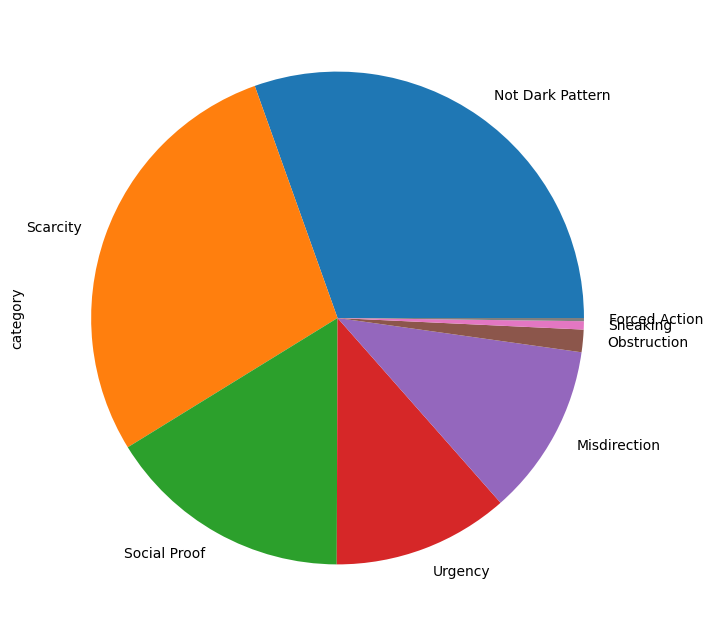

In [10]:
df.category.value_counts().plot(kind="pie", figsize=(8,8))

In [11]:
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

In [12]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=num_fine, id2label=id2fine, label2id=fine2id)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (sequence_summary): SequenceSummary(
    (summary): Linear(in_features=768, out_features=768, bias=True)
    (activation): Tanh()
    (first_dropout): Identity()
    (last

In [13]:
SIZE = df.shape[0]
train_texts = list(df.text[:SIZE//2])
val_texts = list(df.text[SIZE//2:(3*SIZE)//4])
test_texts = list(df.text[(3*SIZE)//4:])
train_labels = list(df.labels[:SIZE//2])
val_labels = list(df.labels[SIZE//2:(3*SIZE)//4])
test_labels = list(df.labels[(3*SIZE)//4:])

In [14]:
len(train_texts), len(val_texts), len(test_texts)

(1934, 967, 967)

In [15]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
class Dataloader(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
train_dataloader = Dataloader(train_encodings, train_labels)
val_dataloader = Dataloader(val_encodings, val_labels)
test_dataloader = Dataloader(test_encodings, test_labels)

In [18]:
from transformers import TrainingArguments, Trainer

In [19]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids

    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)

    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')

    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)

    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [20]:
%pip install transformers[torch] -U
%pip install accelerate -U


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'accelerate\xa0-U'

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [21]:
training_args = TrainingArguments(
    output_dir="./XlBERTModel",
    do_train=True,
    do_eval=True,

    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,

    warmup_steps=100,
    weight_decay=0.01,
    logging_strategy="steps",

    logging_dir="./multi-class-logs",
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    fp16=False,
    load_best_model_at_end=True,
)


In [22]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned
    model=model,

    # training arguments that we defined above
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=val_dataloader,
    compute_metrics=compute_metrics
)


In [23]:
trainer.train()

  0%|          | 0/1452 [00:00<?, ?it/s]

{'loss': 1.8229, 'learning_rate': 2.5e-05, 'epoch': 0.1}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 2.0411086082458496, 'eval_Accuracy': 0.22233712512926576, 'eval_F1': 0.04547377326565143, 'eval_Precision': 0.02779214064115822, 'eval_Recall': 0.125, 'eval_runtime': 32.7401, 'eval_samples_per_second': 29.536, 'eval_steps_per_second': 3.696, 'epoch': 0.1}
{'loss': 1.3052, 'learning_rate': 5e-05, 'epoch': 0.21}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 1.4177279472351074, 'eval_Accuracy': 0.48810754912099275, 'eval_F1': 0.2742917490992024, 'eval_Precision': 0.3491415448891284, 'eval_Recall': 0.31348049434187014, 'eval_runtime': 32.4849, 'eval_samples_per_second': 29.768, 'eval_steps_per_second': 3.725, 'epoch': 0.21}
{'loss': 0.7662, 'learning_rate': 4.81508875739645e-05, 'epoch': 0.31}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.6218994855880737, 'eval_Accuracy': 0.8169596690796277, 'eval_F1': 0.418617269622388, 'eval_Precision': 0.38663546084417777, 'eval_Recall': 0.46375182082819694, 'eval_runtime': 32.8265, 'eval_samples_per_second': 29.458, 'eval_steps_per_second': 3.686, 'epoch': 0.31}
{'loss': 0.7695, 'learning_rate': 4.6301775147928994e-05, 'epoch': 0.41}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4131852686405182, 'eval_Accuracy': 0.8934850051706308, 'eval_F1': 0.5497490241953674, 'eval_Precision': 0.535825795931407, 'eval_Recall': 0.5721179323902638, 'eval_runtime': 32.5912, 'eval_samples_per_second': 29.671, 'eval_steps_per_second': 3.713, 'epoch': 0.41}
{'loss': 0.7265, 'learning_rate': 4.44526627218935e-05, 'epoch': 0.52}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.3585790693759918, 'eval_Accuracy': 0.9348500517063082, 'eval_F1': 0.5777027131961571, 'eval_Precision': 0.57953906996544, 'eval_Recall': 0.5764359259796941, 'eval_runtime': 32.5662, 'eval_samples_per_second': 29.693, 'eval_steps_per_second': 3.716, 'epoch': 0.52}
{'loss': 0.4221, 'learning_rate': 4.260355029585799e-05, 'epoch': 0.62}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.27242618799209595, 'eval_Accuracy': 0.9451913133402275, 'eval_F1': 0.5813035998964765, 'eval_Precision': 0.5931619222710025, 'eval_Recall': 0.576524240203451, 'eval_runtime': 32.5292, 'eval_samples_per_second': 29.727, 'eval_steps_per_second': 3.72, 'epoch': 0.62}
{'loss': 0.3219, 'learning_rate': 4.075443786982249e-05, 'epoch': 0.72}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.48634669184684753, 'eval_Accuracy': 0.9141675284384695, 'eval_F1': 0.65482214709229, 'eval_Precision': 0.6977931600610889, 'eval_Recall': 0.6294937035143224, 'eval_runtime': 32.7955, 'eval_samples_per_second': 29.486, 'eval_steps_per_second': 3.69, 'epoch': 0.72}
{'loss': 0.4, 'learning_rate': 3.8905325443786985e-05, 'epoch': 0.83}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.4664516746997833, 'eval_Accuracy': 0.937952430196484, 'eval_F1': 0.677677022584354, 'eval_Precision': 0.687736017457102, 'eval_Recall': 0.6799032092155111, 'eval_runtime': 32.4605, 'eval_samples_per_second': 29.79, 'eval_steps_per_second': 3.728, 'epoch': 0.83}
{'loss': 0.6595, 'learning_rate': 3.705621301775148e-05, 'epoch': 0.93}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2889283001422882, 'eval_Accuracy': 0.9482936918304034, 'eval_F1': 0.6708593369366175, 'eval_Precision': 0.6475390229316931, 'eval_Recall': 0.7186126443388691, 'eval_runtime': 32.9647, 'eval_samples_per_second': 29.334, 'eval_steps_per_second': 3.671, 'epoch': 0.93}
{'loss': 0.327, 'learning_rate': 3.520710059171598e-05, 'epoch': 1.03}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.28324759006500244, 'eval_Accuracy': 0.9576008273009308, 'eval_F1': 0.5999126549147245, 'eval_Precision': 0.5984959542820261, 'eval_Recall': 0.602472661606438, 'eval_runtime': 35.2277, 'eval_samples_per_second': 27.45, 'eval_steps_per_second': 3.435, 'epoch': 1.03}
{'loss': 0.2185, 'learning_rate': 3.335798816568047e-05, 'epoch': 1.14}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2854589521884918, 'eval_Accuracy': 0.9586349534643226, 'eval_F1': 0.6979841000104057, 'eval_Precision': 0.7127442229599243, 'eval_Recall': 0.6900651434166831, 'eval_runtime': 36.4518, 'eval_samples_per_second': 26.528, 'eval_steps_per_second': 3.319, 'epoch': 1.14}
{'loss': 0.3884, 'learning_rate': 3.150887573964497e-05, 'epoch': 1.24}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.25525322556495667, 'eval_Accuracy': 0.9607032057911065, 'eval_F1': 0.7043584074944587, 'eval_Precision': 0.6843196804437114, 'eval_Recall': 0.7295136303443156, 'eval_runtime': 32.7988, 'eval_samples_per_second': 29.483, 'eval_steps_per_second': 3.689, 'epoch': 1.24}
{'loss': 0.1417, 'learning_rate': 2.965976331360947e-05, 'epoch': 1.34}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.22032350301742554, 'eval_Accuracy': 0.9648397104446742, 'eval_F1': 0.7090769133273663, 'eval_Precision': 0.6942128369902048, 'eval_Recall': 0.7278343513811747, 'eval_runtime': 32.697, 'eval_samples_per_second': 29.575, 'eval_steps_per_second': 3.701, 'epoch': 1.34}
{'loss': 0.3129, 'learning_rate': 2.7810650887573965e-05, 'epoch': 1.45}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2157454639673233, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.6951442707716109, 'eval_Precision': 0.6748995636108848, 'eval_Recall': 0.7291386515128113, 'eval_runtime': 32.595, 'eval_samples_per_second': 29.667, 'eval_steps_per_second': 3.712, 'epoch': 1.45}
{'loss': 0.3211, 'learning_rate': 2.5961538461538464e-05, 'epoch': 1.55}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.24000579118728638, 'eval_Accuracy': 0.9617373319544984, 'eval_F1': 0.7013868912249586, 'eval_Precision': 0.6957380551384367, 'eval_Recall': 0.7092259740544555, 'eval_runtime': 32.7899, 'eval_samples_per_second': 29.491, 'eval_steps_per_second': 3.69, 'epoch': 1.55}
{'loss': 0.401, 'learning_rate': 2.411242603550296e-05, 'epoch': 1.65}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.24523209035396576, 'eval_Accuracy': 0.9627714581178903, 'eval_F1': 0.6961115983634263, 'eval_Precision': 0.6782696713529204, 'eval_Recall': 0.7242473795057426, 'eval_runtime': 33.931, 'eval_samples_per_second': 28.499, 'eval_steps_per_second': 3.566, 'epoch': 1.65}
{'loss': 0.279, 'learning_rate': 2.2263313609467456e-05, 'epoch': 1.76}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2290949821472168, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.710038051239947, 'eval_Precision': 0.7063080174800329, 'eval_Recall': 0.7139190591780294, 'eval_runtime': 34.0956, 'eval_samples_per_second': 28.361, 'eval_steps_per_second': 3.549, 'epoch': 1.76}
{'loss': 0.3125, 'learning_rate': 2.0414201183431952e-05, 'epoch': 1.86}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2231772541999817, 'eval_Accuracy': 0.9669079627714581, 'eval_F1': 0.7097310793435827, 'eval_Precision': 0.711250098535996, 'eval_Recall': 0.7089257522992178, 'eval_runtime': 32.4518, 'eval_samples_per_second': 29.798, 'eval_steps_per_second': 3.729, 'epoch': 1.86}
{'loss': 0.294, 'learning_rate': 1.856508875739645e-05, 'epoch': 1.96}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2293274849653244, 'eval_Accuracy': 0.9700103412616339, 'eval_F1': 0.7131999264913138, 'eval_Precision': 0.7125306753040179, 'eval_Recall': 0.7140225953360415, 'eval_runtime': 32.1782, 'eval_samples_per_second': 30.051, 'eval_steps_per_second': 3.76, 'epoch': 1.96}
{'loss': 0.1059, 'learning_rate': 1.6715976331360947e-05, 'epoch': 2.07}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2402098923921585, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.7086306831509461, 'eval_Precision': 0.6902714811359228, 'eval_Recall': 0.7338941339898704, 'eval_runtime': 32.1158, 'eval_samples_per_second': 30.11, 'eval_steps_per_second': 3.768, 'epoch': 2.07}
{'loss': 0.1747, 'learning_rate': 1.4866863905325445e-05, 'epoch': 2.17}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.24635878205299377, 'eval_Accuracy': 0.9669079627714581, 'eval_F1': 0.7101803619092846, 'eval_Precision': 0.7110615824369204, 'eval_Recall': 0.7098497411311376, 'eval_runtime': 32.17, 'eval_samples_per_second': 30.059, 'eval_steps_per_second': 3.761, 'epoch': 2.17}
{'loss': 0.1803, 'learning_rate': 1.3017751479289941e-05, 'epoch': 2.27}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.21563509106636047, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.704635225302827, 'eval_Precision': 0.6968619684694806, 'eval_Recall': 0.7135165341880976, 'eval_runtime': 32.0992, 'eval_samples_per_second': 30.125, 'eval_steps_per_second': 3.77, 'epoch': 2.27}
{'loss': 0.094, 'learning_rate': 1.1168639053254439e-05, 'epoch': 2.38}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2200087159872055, 'eval_Accuracy': 0.9669079627714581, 'eval_F1': 0.7037278750291462, 'eval_Precision': 0.6951082358920695, 'eval_Recall': 0.7133450127490719, 'eval_runtime': 33.8918, 'eval_samples_per_second': 28.532, 'eval_steps_per_second': 3.57, 'epoch': 2.38}
{'loss': 0.1279, 'learning_rate': 9.319526627218936e-06, 'epoch': 2.48}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2172452211380005, 'eval_Accuracy': 0.9700103412616339, 'eval_F1': 0.7089558673402262, 'eval_Precision': 0.6924230395984353, 'eval_Recall': 0.7321696213596394, 'eval_runtime': 34.6938, 'eval_samples_per_second': 27.872, 'eval_steps_per_second': 3.488, 'epoch': 2.48}
{'loss': 0.1425, 'learning_rate': 7.470414201183433e-06, 'epoch': 2.58}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.21860143542289734, 'eval_Accuracy': 0.9700103412616339, 'eval_F1': 0.7080879215783193, 'eval_Precision': 0.6890914375930395, 'eval_Recall': 0.7340412747990452, 'eval_runtime': 34.087, 'eval_samples_per_second': 28.369, 'eval_steps_per_second': 3.55, 'epoch': 2.58}
{'loss': 0.0801, 'learning_rate': 5.621301775147929e-06, 'epoch': 2.69}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.22165095806121826, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.706819193999112, 'eval_Precision': 0.687257182704933, 'eval_Recall': 0.7334162747990451, 'eval_runtime': 33.9624, 'eval_samples_per_second': 28.473, 'eval_steps_per_second': 3.563, 'epoch': 2.69}
{'loss': 0.1254, 'learning_rate': 3.772189349112426e-06, 'epoch': 2.79}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.21351629495620728, 'eval_Accuracy': 0.9700103412616339, 'eval_F1': 0.7022859614195749, 'eval_Precision': 0.6831425518925518, 'eval_Recall': 0.7315717714254577, 'eval_runtime': 34.1684, 'eval_samples_per_second': 28.301, 'eval_steps_per_second': 3.541, 'epoch': 2.79}
{'loss': 0.2345, 'learning_rate': 1.9230769230769234e-06, 'epoch': 2.89}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2192179262638092, 'eval_Accuracy': 0.96794208893485, 'eval_F1': 0.7000568952322972, 'eval_Precision': 0.6822896217550205, 'eval_Recall': 0.7279485830196606, 'eval_runtime': 33.0801, 'eval_samples_per_second': 29.232, 'eval_steps_per_second': 3.658, 'epoch': 2.89}
{'loss': 0.1508, 'learning_rate': 7.396449704142013e-08, 'epoch': 3.0}


  0%|          | 0/121 [00:00<?, ?it/s]

c:\Users\sj210\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'eval_loss': 0.2175927311182022, 'eval_Accuracy': 0.9689762150982419, 'eval_F1': 0.7006561223567607, 'eval_Precision': 0.6828607564170917, 'eval_Recall': 0.7285735830196607, 'eval_runtime': 33.1706, 'eval_samples_per_second': 29.152, 'eval_steps_per_second': 3.648, 'epoch': 3.0}
{'train_runtime': 1824.6063, 'train_samples_per_second': 3.18, 'train_steps_per_second': 0.796, 'train_loss': 0.3996535313418154, 'epoch': 3.0}


TrainOutput(global_step=1452, training_loss=0.3996535313418154, metrics={'train_runtime': 1824.6063, 'train_samples_per_second': 3.18, 'train_steps_per_second': 0.796, 'train_loss': 0.3996535313418154, 'epoch': 3.0})

In [24]:

def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs['logits'].softmax(1)
    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label

    # Since pred_label_idx is a tensor containing a single value (the predicted class index),
    # the .item() method is used to extract the value as a scalar

    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label



In [25]:
model_path = "Titans_DPBH_XLNet_Fine_Tuned_Model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('Titans_DPBH_XLNet_Fine_Tuned_Model\\tokenizer_config.json',
 'Titans_DPBH_XLNet_Fine_Tuned_Model\\special_tokens_map.json',
 'Titans_DPBH_XLNet_Fine_Tuned_Model\\tokenizer.json')

In [26]:
# Reload the model

model_path = "Titans_DPBH_XLNet_Fine_Tuned_Model"

model = XLNetForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [27]:
nlp("Haris just bought an underwear at just rs 99")

[{'label': 'Social Proof', 'score': 0.9998997449874878}]

In [28]:
nlp("i dont want any knowledge")

[{'label': 'Misdirection', 'score': 0.9996906518936157}]

In [29]:
nlp("I want to buy and eat some ice cream today.")

[{'label': 'Misdirection', 'score': 0.9996703863143921}]